# Data Loading

In [2]:
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

In [4]:
df = pd.read_csv(TRAIN_PATH)

In [5]:
df.head()

,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    1096 non-null   float64
 1   SWTI    1096 non-null   float64
 2   CWTI    1096 non-null   float64
 3   EI      1096 non-null   float64
 4   Class   1096 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 42.9 KB


In [8]:
X = df.drop(columns=['Class'])
y = df['Class']

# Обучение модели

## Бозовая модель

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [11]:
acc = accuracy_score(y_valid, y_pred_base)
prec = precision_score(y_valid, y_pred_base)
rec = recall_score(y_valid, y_pred_base)

In [12]:
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)


Accuracy: 0.990909090909091
Precision: 0.9770114942528736
Recall: 1.0


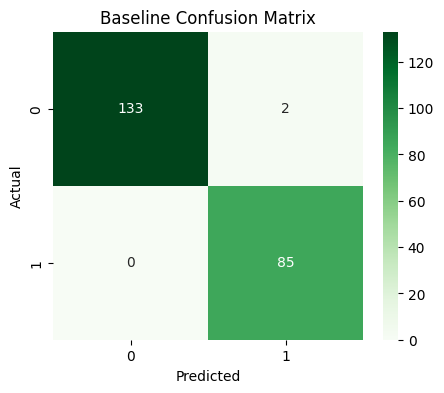

In [13]:
cm = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

## Улучшенная модель

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
best_acc = 0
best_model = None
best_params = None


for trees in [50, 100, 150, 200]:
    for depth in [None, 5, 7, 10, 15]:
        model = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        score = accuracy_score(y_valid, preds)
        if score > best_acc:
            best_acc = score
            best_model = model
            best_params = (trees, depth)

In [19]:
print(best_params)

(50, None)


In [20]:
y_pred_imp = best_model.predict(X_valid)
acc2 = accuracy_score(y_valid, y_pred_imp)
prec2 = precision_score(y_valid, y_pred_imp)
rec2 = recall_score(y_valid, y_pred_imp)

In [21]:
print("Accuracy:", acc2)
print("Precision:", prec2)
print("Recall:", rec2)

Accuracy: 0.9969604863221885
Precision: 0.9931972789115646
Recall: 1.0


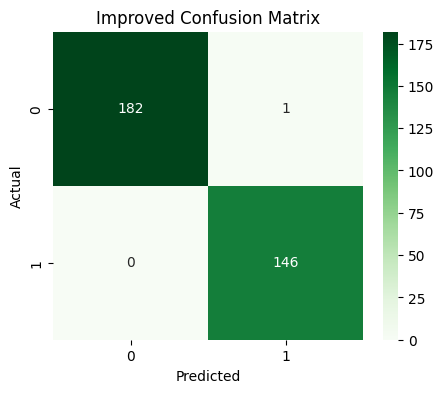

In [22]:
cm2 = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Confusion Matrix')
plt.show()

Метрики стали чуть лучше после изменения гиперпараметров

##  Реализованная модель

In [40]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

class RFNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class SimpleDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None

    def build(self, X, y, depth):
        # Base case: create leaf node
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            gini_impurity(y) == 0):
            values, counts = np.unique(y, return_counts=True)
            return RFNode(value=values[np.argmax(counts)])
        
        # Select random subset of features
        n_features = X.shape[1]
        features = np.random.choice(
            n_features, 
            size=min(self.max_features, n_features), 
            replace=False
        )
        
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        
        # Evaluate all possible splits
        for feature in features:
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                g_left = gini_impurity(left_y)
                g_right = gini_impurity(right_y)
                
                weighted_gini = (len(left_y) / len(y)) * g_left + \
                               (len(right_y) / len(y)) * g_right
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = t

        if best_feature is None:
            values, counts = np.unique(y, return_counts=True)
            return RFNode(value=int(values[np.argmax(counts)]))
        
        left_mask = X[:, best_feature] <= best_threshold
        left = self.build(X[left_mask], y[left_mask], depth + 1)
        right = self.build(X[~left_mask], y[~left_mask], depth + 1)
        
        return RFNode(best_feature, best_threshold, left, right)

    def fit(self, X, y):
        self.root = self.build(X, y, 0)
    
    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)
    
    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        idx = np.random.choice(len(X), len(X), replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.trees = []
        # Set default max_features if not specified
        if self.max_features is None:
            self.max_features = int(np.sqrt(X.shape[1]))
        
        for _ in range(self.n_estimators):
            X_s, y_s = self.bootstrap_sample(X, y)
            tree = SimpleDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        final = []

        for i in range(len(X)):
            vals, counts = np.unique(preds[:, i], return_counts=True)
            final.append(vals[np.argmax(counts)])

        final = np.array(final, dtype=int)
        return final

## Базовая реализованная модель

In [41]:
X_train_np = X_train.values
y_train_np = y_train.values.astype(int)
X_valid_np = X_valid.values
y_valid_np = y_valid.values.astype(int)

In [42]:
rf_scratch = RandomForestScratch()
rf_scratch.fit(X_train_np, y_train_np)
y_pred_scratch = rf_scratch.predict(X_valid_np)

y_pred_scratch = y_pred_scratch.astype(int)

In [43]:
acc_s = accuracy_score(y_valid_np, y_pred_scratch)
prec_s = precision_score(y_valid_np, y_pred_scratch)
rec_s = recall_score(y_valid_np, y_pred_scratch)

In [44]:
print("Accuracy:", acc_s)
print("Precision:", prec_s)
print("Recall:", rec_s)

Accuracy: 0.9787234042553191
Precision: 0.9727891156462585
Recall: 0.9794520547945206


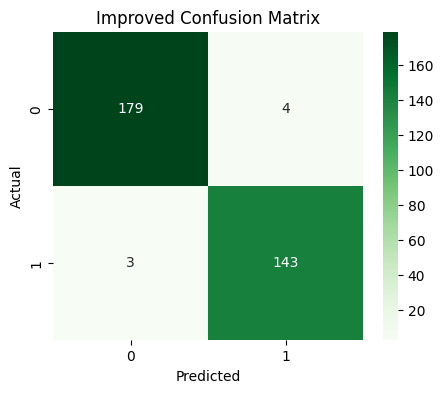

In [45]:
cm3 = confusion_matrix(y_valid, y_pred_scratch)
plt.figure(figsize=(5,4))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Confusion Matrix')
plt.show()

## Улучшенная реализованная модель

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [47]:
X_train_np = X_train.values
y_train_np = y_train.values.astype(int)
X_valid_np = X_valid.values
y_valid_np = y_valid.values.astype(int)

In [68]:
rf_scratch = RandomForestScratch(n_estimators=50, min_samples_split=3, max_depth=5)
rf_scratch.fit(X_train_np, y_train_np)
y_pred_scratch = rf_scratch.predict(X_valid_np)

y_pred_scratch = y_pred_scratch.astype(int)

In [69]:
acc_s = accuracy_score(y_valid_np, y_pred_scratch)
prec_s = precision_score(y_valid_np, y_pred_scratch)
rec_s = recall_score(y_valid_np, y_pred_scratch)

In [70]:
print("Accuracy:", acc_s)
print("Precision:", prec_s)
print("Recall:", rec_s)

Accuracy: 0.9848024316109423
Precision: 0.9795918367346939
Recall: 0.9863013698630136


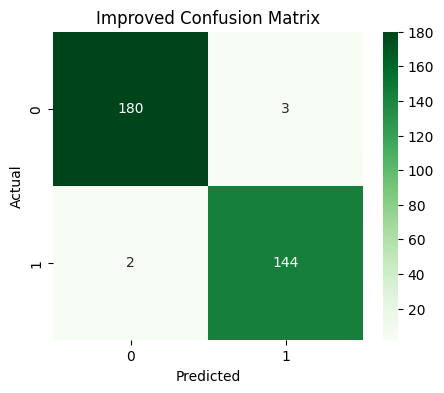

In [71]:
cm4 = confusion_matrix(y_valid, y_pred_scratch)
plt.figure(figsize=(5,4))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Confusion Matrix')
plt.show()

# Data loading

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [97]:
DATA_PATH = "Dataset/Water/water_consumption.csv"

In [98]:
df = pd.read_csv(DATA_PATH)

In [99]:
df.head()

,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [100]:
df = df.rename(columns={
"Country": "country",
"Year": "year",
"Total Water Consumption (Billion Cubic Meters)": "total_consumption",
"Per Capita Water Use (Liters per Day)": "per_capita_use",
"Agricultural Water Use (%)": "agricultural_use",
"Industrial Water Use (%)": "industrial_use",
"Household Water Use (%)": "household_use",
"Rainfall Impact (Annual Precipitation in mm)": "rainfall",
"Groundwater Depletion Rate (%)": "groundwater_depletion",
"Water Scarcity Level": "scarcity_level"
})

# Обучение модели

Подготовка к обучению

In [145]:
df_sorted = df.sort_values('year')
train = df_sorted[df_sorted.year < df_sorted.year.max() - 4]
valid = df_sorted[df_sorted.year >= df_sorted.year.max() - 4]

Обучение модели

In [146]:
X_train = train.drop(columns=['total_consumption'])
y_train = train['total_consumption']
X_valid = valid.drop(columns=['total_consumption'])
y_valid = valid['total_consumption']

In [147]:
numeric = X_train.select_dtypes(include=[np.number]).columns
categorical = X_train.select_dtypes(include=[object]).columns

## Базовая модель

In [104]:
baseline_preprocessor = ColumnTransformer([
("onehot", OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

In [105]:
baseline_model = Pipeline([
("prep", baseline_preprocessor),
("rf", RandomForestRegressor())
])

In [106]:
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [130]:
mae_base = mean_absolute_error(y_valid, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_valid, y_pred_base))
mae_percent_base = mae_base / y_valid.mean() * 100

In [131]:
print("MAE:", mae_base)
print("RMSE:", rmse_base)
print("MAE%:", mae_percent_base)

MAE: 79.89701583254997
RMSE: 107.20301518019302
MAE%: 16.15915787277912


## Улучшенная модель

In [132]:
best_mae = 1e18
best_model = None
best_params = None


for trees in [100, 200, 300]:
    for depth in [None, 5, 8, 12]:
        for leaf in [1, 2, 4]:
            model = Pipeline([
            ("prep", baseline_preprocessor),
            ("rf", RandomForestRegressor(
            n_estimators=trees,
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
            ))
        ])
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, preds)
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_params = (trees, depth, leaf)

In [133]:
print("\nBest parameters:", best_params)


Best parameters: (100, 5, 4)


In [134]:
improved_model = Pipeline([
("prep", baseline_preprocessor),
("rf", RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4))
])

In [135]:
improved_model.fit(X_train, y_train)

y_pred_imp = improved_model.predict(X_valid)

In [136]:
mae_imp = mean_absolute_error(y_valid, y_pred_imp)
rmse_imp = np.sqrt(mean_squared_error(y_valid, y_pred_imp))
mae_percent_imp = mae_imp / y_valid.mean() * 100

In [137]:
print("MAE:", mae_imp)
print("RMSE:", rmse_imp)
print("MAE%:", mae_percent_imp)

MAE: 76.52026880886493
RMSE: 101.54190536924632
MAE%: 15.476211361153167


## Реализованная модель

In [138]:
def mse(y):
    """Mean Squared Error for regression."""
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y)) ** 2)

class RFRegNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # leaf value (mean)

class SimpleRegressionTree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None

    def build(self, X, y, depth):
        # stopping criteria
        if (
            depth >= self.max_depth
            or len(y) < self.min_samples_split
            or mse(y) == 0
        ):
            return RFRegNode(value=np.mean(y))  # leaf value

        n_features = X.shape[1]

        # random subset of features (RF core trick)
        features = np.random.choice(
            n_features,
            size=min(self.max_features, n_features),
            replace=False
        )

        best_feature = None
        best_threshold = None
        best_mse = float("inf")

        # find best split
        for feature in features:
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = ~left_mask

                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                left_y = y[left_mask]
                right_y = y[right_mask]

                # weighted MSE
                weighted = (len(left_y)/len(y))*mse(left_y) + \
                           (len(right_y)/len(y))*mse(right_y)

                if weighted < best_mse:
                    best_mse = weighted
                    best_feature = feature
                    best_threshold = t

        # fallback — no split found
        if best_feature is None:
            return RFRegNode(value=np.mean(y))

        # recursive growth
        left_mask = X[:, best_feature] <= best_threshold
        
        left = self.build(X[left_mask], y[left_mask], depth+1)
        right = self.build(X[~left_mask], y[~left_mask], depth+1)

        return RFRegNode(best_feature, best_threshold, left, right)

    def fit(self, X, y):
        self.root = self.build(X, y, 0)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

In [139]:
class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, max_depth=5,
                 min_samples_split=2, max_features=None):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def bootstrap(self, X, y):
        idx = np.random.choice(len(X), len(X), replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.trees = []

        # default number of features (RF rule)
        if self.max_features is None:
            self.max_features = int(np.sqrt(X.shape[1]))

        for _ in range(self.n_estimators):
            X_s, y_s = self.bootstrap(X, y)
            tree = SimpleRegressionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

In [140]:
X_train_np = X_train.values
y_train_np = y_train.values.astype(float)

X_valid_np = X_valid.values
y_valid_np = y_valid.values.astype(float)

In [141]:
rf_reg = RandomForestRegressorScratch()
rf_reg.fit(X_train_np, y_train_np)
y_pred_reg = rf_reg.predict(X_valid_np)

In [143]:
mae_imp = mean_absolute_error(y_valid_np, y_pred_reg)
rmse_imp = np.sqrt(mean_squared_error(y_valid_np, y_pred_reg))

mae_percent_imp = mae_imp / np.mean(y_valid_np) * 100

In [144]:
print("MAE:", mae_imp)
print("RMSE:", rmse_imp)
print("MAE%:", mae_percent_imp)

MAE: 79.53960402767238
RMSE: 107.02066740924231
MAE%: 16.086871395988595


## Улучшенная релизованная модель

In [153]:
X_train_np = X_train.values
y_train_np = y_train.values.astype(float)

X_valid_np = X_valid.values
y_valid_np = y_valid.values.astype(float)

In [156]:
rf_reg = RandomForestRegressorScratch(n_estimators=100, max_depth=5)
rf_reg.fit(X_train_np, y_train_np)
y_pred_reg = rf_reg.predict(X_valid_np)

In [157]:
mae_imp = mean_absolute_error(y_valid_np, y_pred_reg)
rmse_imp = np.sqrt(mean_squared_error(y_valid_np, y_pred_reg))

mae_percent_imp = mae_imp / np.mean(y_valid_np) * 100

In [158]:
print("MAE:", mae_imp)
print("RMSE:", rmse_imp)
print("MAE%:", mae_percent_imp)

MAE: 77.77725213244774
RMSE: 102.39849683070304
MAE%: 15.956064631849479


# Результаты

## Классификация

In [160]:
results_dfc = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.990909090909091, 0.9969604863221885, 
                 0.9787234042553191, 0.9848024316109423],
    'Precision': [0.9770114942528736, 0.9931972789115646, 
                  0.9727891156462585, 0.9795918367346939],
    'Recall': [1.0, 1.0, 0.9794520547945206, 0.9863013698630136]
})


In [161]:
results_dfc

,Модель,Accuracy,Precision,Recall
0,Базовая модель,0.990909,0.977011,1.000000
1,Улучшенная модель,0.996960,0.993197,1.000000
2,Реализованная базовая модель,0.978723,0.972789,0.979452
3,Улучшенная реализованная модель,0.984802,0.979592,0.986301


## Регрессия

In [162]:
results_dfr = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'MAE': [79.89701583254997, 76.52026880886493, 
            79.53960402767238, 77.77725213244774],
    'RMSE': [107.20301518019302, 101.54190536924632, 
             107.02066740924231, 102.39849683070304]
})

In [163]:
results_dfr

,Модель,MAE,RMSE
0,Базовая модель,79.897016,107.203015
1,Улучшенная модель,76.520269,101.541905
2,Реализованная базовая модель,79.539604,107.020667
3,Улучшенная реализованная модель,77.777252,102.398497
